# Projekt Data Analytics
## Przewidywanie i analiza stanu cywilnego ludności USA na przestrzeni lat 

Autorzy: Julia Nowak, Adam Złocki

### 1. Sformuowanie problemu


##### Główny problem
Celem projektu jest predykcja procentowego udziału dorosłych osób po ślubie, rozwiedzionych oraz takich, które nigdy nie brały ślubu w społeczeństwie USA.
Problem nie skupia się na konkretnych rasach ludzi – przyjęte zostały dane ogólne,
wspólne dla wszystkich ras. Dobrany zestaw danych umożliwia jednak podzielenie danych na konkretne rasy oraz odrębną analizę stanu cywilnego. Idea projektu została oparta o aktualny temat dotyczący hipotetycznego spadku liczby małżeństw oraz wzrostu liczby rozwodów
w krajach wysoko rozwiniętych, takich jak USA. Podczas analizy chcemy wykazać istniejące trendy oraz przewidzieć rozkład interesujących nas wartości w przyszłości.

##### Przykłady użycia i powody analizy
Problem predykcji stanu cywilnego oraz przewidywanie procentowej ilości m.in. małżeństw
w społeczeństwie jest z punktu widzenia państwa niezwykle istotną informacją.
Jest to problem, który warto analizować chociażby pod kątem planowania przez rząd Stanów Zjednoczonych polityki prorodzinnej. Temat jest istotny także przy wszelkiego rodzaju oszacowaniach związanych z przyrostem naturalnym czy uwarunkowaniami społecznymi. Analiza może wskazać rządowi ze znacznym wyprzedzeniem, iż w społeczeństwie zachodzą pewne zmiany, które warto wziąć pod uwagę przy tworzeniu przyszłych planów.

##### Pochodzenie i zawartość danych
Dane, które są przez nas wykorzystywane, pochodzą z oficjalnej strony rządowej USA (www.census.gov). Zawierają one informacje o liczbie osób o danym stanie cywilnym w zależności od roku, średnim wieku zawarcia pierwszego małżeństwa oraz o całkowitym, średnim przychodzie na członka gospodarstwa domowego w celu zaprezentowania ogólnej sytuacji materialnej społeczeństwa. Dane dotyczące liczby ludności wymagają ustandaryzowania, ze względu na zmieniającą się sumaryczną wartość – stąd logiczne wydaje się operowanie na wartościach procentowych.
Dodatkowo dostępne są również identyczne dane z uwzględnieniem podziału na rasy,
a więc możliwe jest przeprowadzenie predykcji dla każdej z nich osobno, a następnie wykonanie analizy porównawczej, zarówno rzeczywistych, jak i przewidywanych wartości.
Wykorzystywane przez nas dane są danymi historycznymi, uzupełnianymi od XX wieku do 2023 roku. Ich ostatnia aktualizacja miała miejsce w listopadzie 2023 roku – są to więc dane stosunkowo świeże. Do analizy przyjęte zostały lata 2020 – 2022, z pominięciem duplikatów niektórych lat (z każdej pary wybrano dane odświeżone).
Dane uwzględniają różne tabele pochodzące z Ankiet Obecnej Populacji (ang. Current Population Survey; CPS), przeprowadzanych co roku przez cenzus w USA.

##### Schemat DAG
TO  DO


### 2. Preprocessing - wstępne przetwarzanie danych

- is preprocessing step clearly described [1 pt]
- reasoning and types of actions taken on the dataset have been described [1 pt]

##### Import niezbędnych bibliotek

In [297]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [298]:
df = pd.read_excel("test.xlsx", sheet_name="Arkusz1")
df = pd.read_excel("test.xlsx")
df = df[['Year', 'Married', 'Income', "Mean age", "Household"]]

In [299]:
df = df.sort_values('Year', ascending=True)
df.head()

,Year,Married,Income,Mean age,Household
22,2000,120211,22130,25.95,104705
21,2001,123098,22570,26.00,108209
20,2002,123370,22530,26.10,109297
19,2003,125034,22970,26.20,111278
18,2004,125880,23550,26.35,112000


In [300]:
df.describe()

,Year,Married,Income,Mean age,Household
count,23.00000,23.000000,23.000000,23.000000,23.000000
mean,2011.00000,130663.173913,29424.347826,27.493478,119526.086957
std,6.78233,4969.723969,5971.686853,1.174086,7576.810008
min,2000.00000,120211.000000,22130.000000,25.950000,104705.000000
25%,2005.50000,127473.000000,25355.000000,26.425000,113863.500000
50%,2011.00000,130767.000000,28070.000000,27.400000,119927.000000
75%,2016.50000,134924.500000,33425.000000,28.450000,126021.500000
max,2022.00000,137772.000000,42330.000000,29.450000,131202.000000


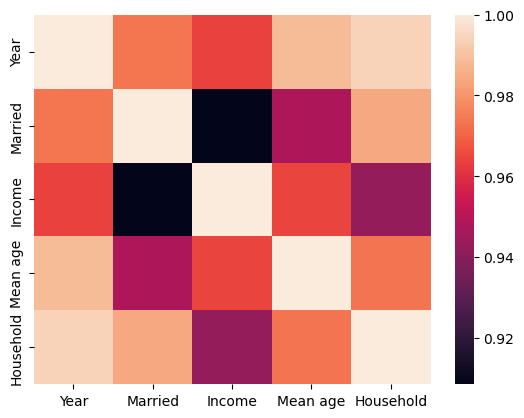

In [301]:
new = df.corr()
sns.heatmap(new)
plt.show()

In [302]:
def scale_correlation(x):
    a = 100 / 7
    b = -93 / 7
    return a * x + b

# Apply the scaling function to each element of the correlation matrix
scaled_corr_matrix = new.applymap(scale_correlation)

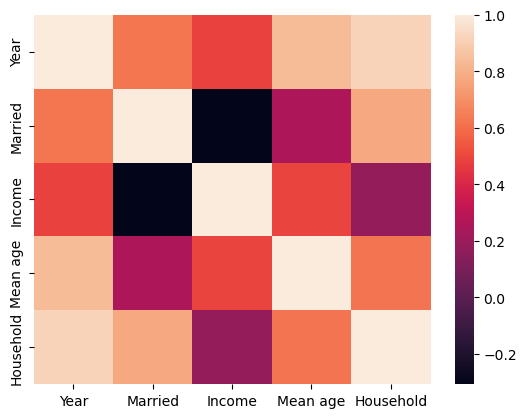

In [303]:
sns.heatmap(scaled_corr_matrix)
plt.show()

In [304]:
new

,Year,Married,Income,Mean age,Household
Year,1.000000,0.973903,0.964185,0.988373,0.993961
Married,0.973903,1.000000,0.908483,0.947680,0.984306
Income,0.964185,0.908483,1.000000,0.964535,0.942613
Mean age,0.988373,0.947680,0.964535,1.000000,0.973480
Household,0.993961,0.984306,0.942613,0.973480,1.000000


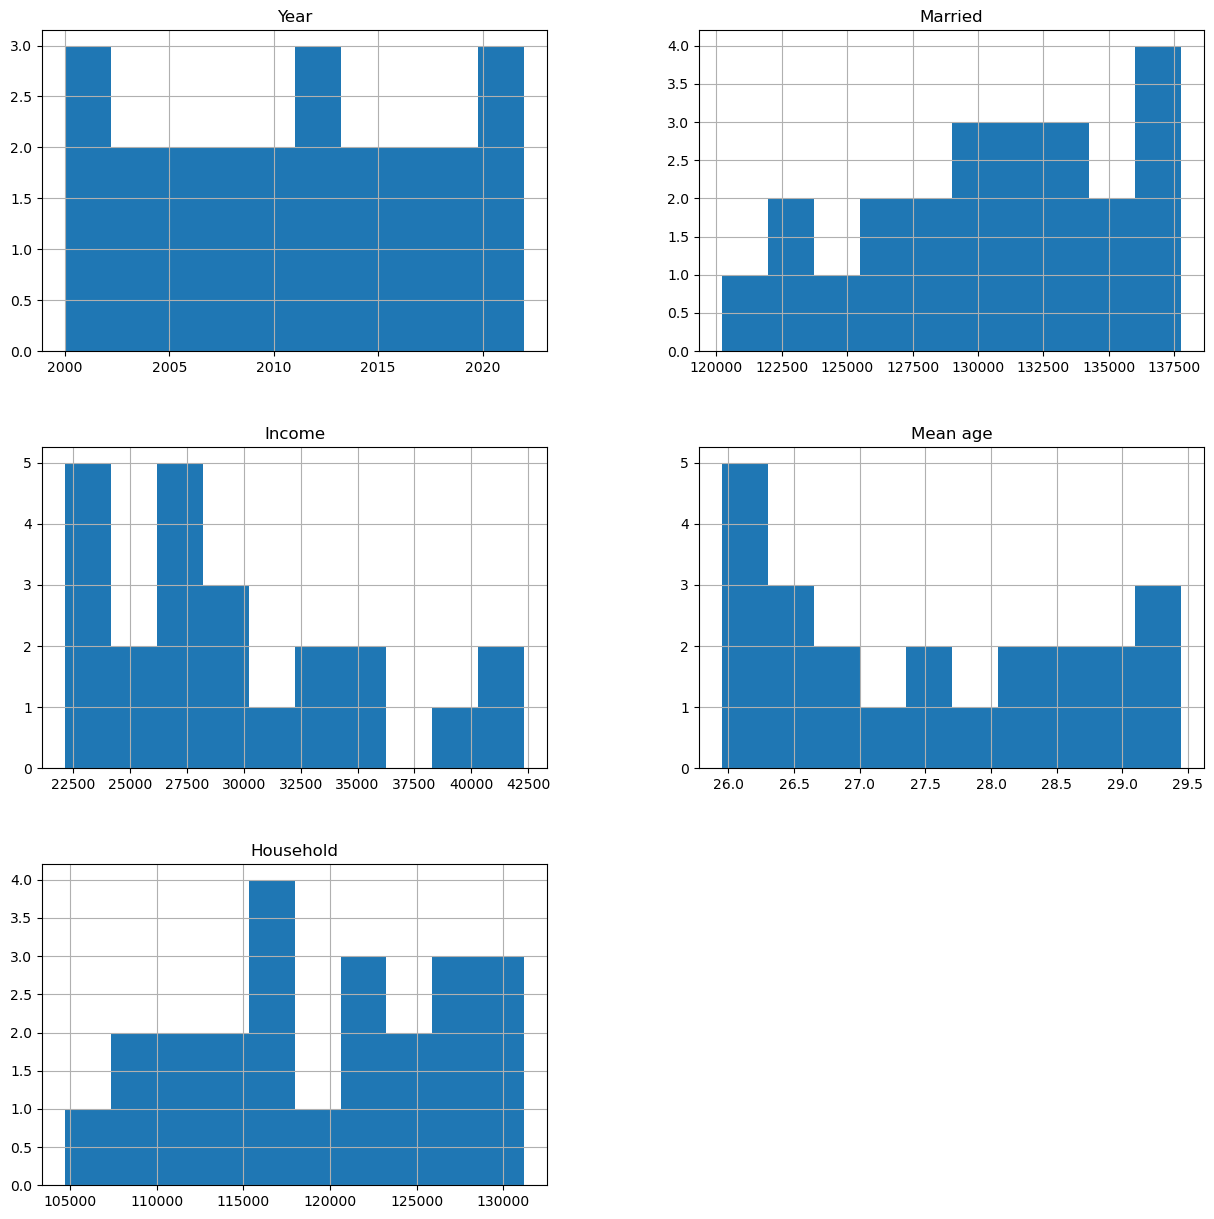

In [305]:

df.hist(figsize=(15,15), bins=10)
plt.show()

In [306]:
import warnings
import cmdstanpy
warnings.filterwarnings('ignore')
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

### 3. Utworzenie modeli

- Mamy 2 modele - jeden przewidujący liczbę/procent osób po ślubie na podstawie samych danych o przychodzie oraz drugi - przewidujący liczbę/procent osób po ślubie na podstawie przychodu, wieku??? oraz liczby obecnych miejsc zamieszkania

- Modele różnią się liczbą przyjętych predyktorów

- Większa liczba predyktorów może przyczynić się do otrzymania lepszych, bardziej zbliżonych do rzeczwistości wyników

- ??????are models sufficiently described (what are formulas, what are parameters, what data are required ) [1 pt]

In [307]:
# model = CmdStanModel(stan_file='model_1_prior.stan')
model = CmdStanModel(stan_file='model_prior.stan')
post_model = CmdStanModel(stan_file='model.stan')
model_2_prior = CmdStanModel(stan_file='triparam_model.stan')
model_2_posterior = CmdStanModel(stan_file='triparam_model_posterior.stan')

N = 23
R = 100

### 4. Priors

- Is it explained why particular priors for parameters were selected [1 pt]
- Have prior predictive checks been done for parameters (are parameters simulated from priors make sense) [1 pt]
- Have prior predictive checks been done for measurements (are measurements simulated from priors make sense) [1 pt]
- How prior parameters were selected [1 pt]

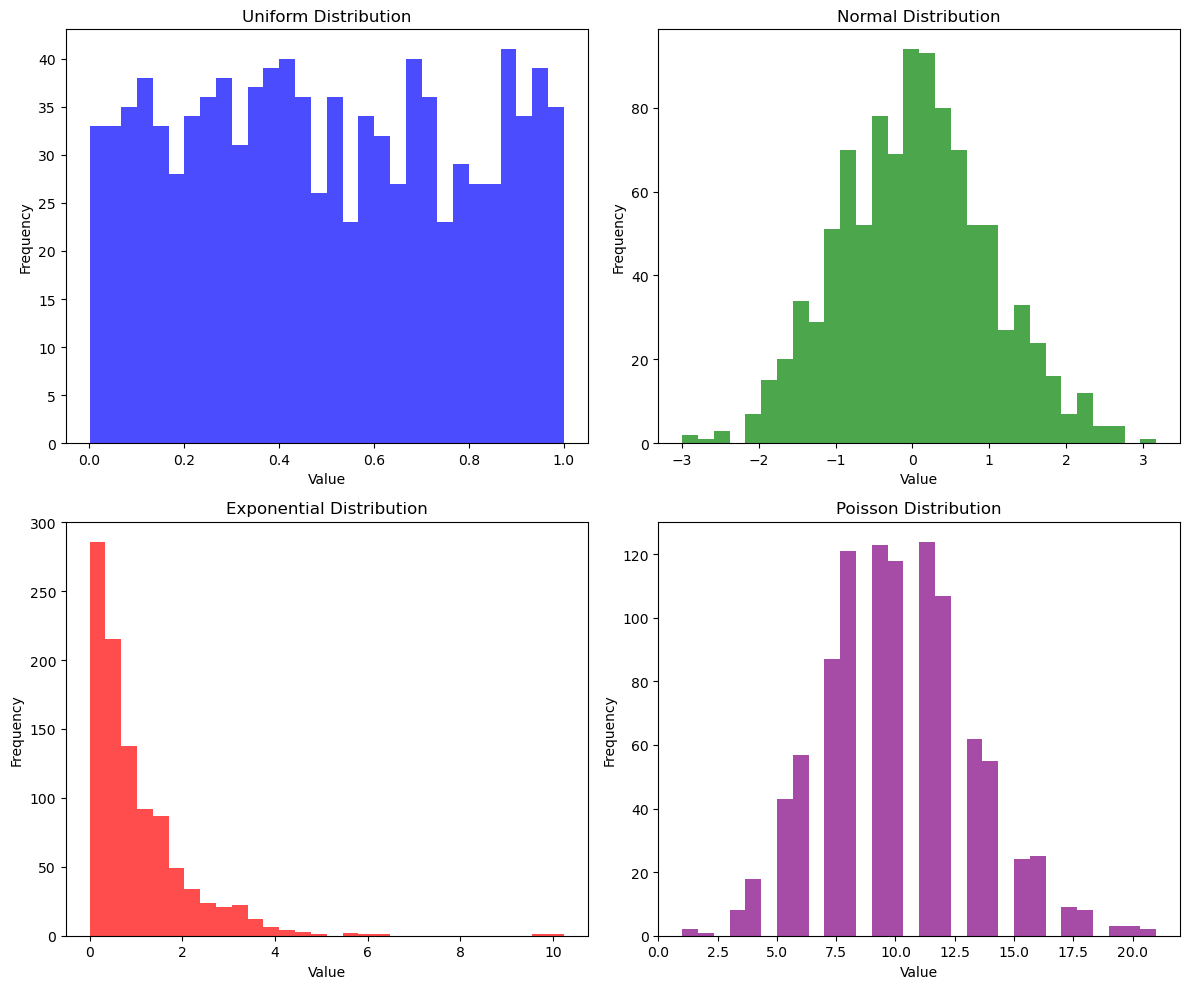

In [308]:
import numpy as np
import matplotlib.pyplot as plt

# Set the seed for reproducibility
np.random.seed(0)

# Number of samples
n_samples = 1000

# Generate data for different distributions
uniform_data = np.random.uniform(low=0.0, high=1.0, size=n_samples)
normal_data = np.random.normal(loc=0.0, scale=1.0, size=n_samples)
exponential_data = np.random.exponential(scale=1.0, size=n_samples)
poisson_data = np.random.poisson(lam=10.0, size=n_samples)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Plot uniform distribution
axs[0, 0].hist(uniform_data, bins=30, color='blue', alpha=0.7)
axs[0, 0].set_title('Uniform Distribution')
axs[0, 0].set_xlabel('Value')
axs[0, 0].set_ylabel('Frequency')

# Plot normal distribution
axs[0, 1].hist(normal_data, bins=30, color='green', alpha=0.7)
axs[0, 1].set_title('Normal Distribution')
axs[0, 1].set_xlabel('Value')
axs[0, 1].set_ylabel('Frequency')

# Plot exponential distribution
axs[1, 0].hist(exponential_data, bins=30, color='red', alpha=0.7)
axs[1, 0].set_title('Exponential Distribution')
axs[1, 0].set_xlabel('Value')
axs[1, 0].set_ylabel('Frequency')

# Plot poisson distribution
axs[1, 1].hist(poisson_data, bins=30, color='purple', alpha=0.7)
axs[1, 1].set_title('Poisson Distribution')
axs[1, 1].set_xlabel('Value')
axs[1, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[125230.43037602 126320.1058047  126871.89751377 125988.54859267
 125074.96382344 127794.03697428 127905.10929068 127340.84104544
 130327.19703087 130812.58129028 129786.32624731 130907.06392712
 131246.38301465 131639.89203482 132246.96899178 132717.69809252
 133185.76501795 136141.45178537 136035.96155237 138718.27304911
 137476.19272492 138382.6488388  142242.66319127]


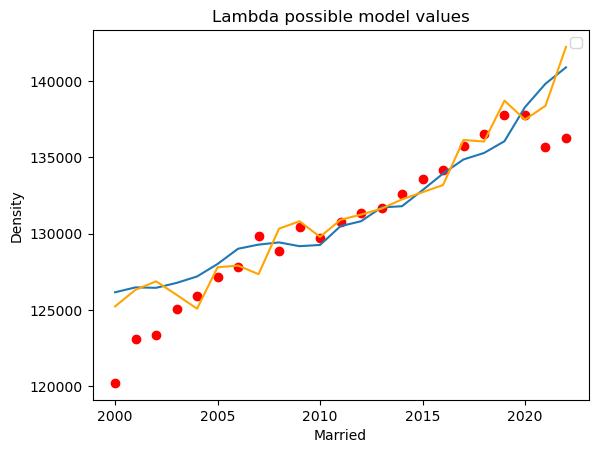

In [309]:
from numpy import random
beta = 110000
alpha = 0.73

v = random.poisson(alpha*df['Income'] + beta)
v = random.normal(alpha*df['Income'] + beta, 1000)
print(v)
# plt.hist(df['Married'], bins=10, color='red', density=True, label='True data')
plt.scatter(df['Year'], df['Married'], color='red')
plt.plot(df['Year'], alpha*df['Income'] + beta)
plt.plot(df['Year'], v, color='orange')
plt.title('Lambda possible model values')
plt.xlabel('Married')
plt.ylabel('Density')
plt.legend()
plt.show()

In [310]:
data = {'N': N, 'income': df['Income']}
gen_1 = model.sample(
                    data=data,
                    iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

16:40:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


16:40:18 - cmdstanpy - INFO - CmdStan done processing.


In [311]:
gen_1.draws_pd()

,lp__,accept_stat__,alpha,beta,sigma,y_sim[1],y_sim[2],y_sim[3],y_sim[4],y_sim[5],...,y_sim[14],y_sim[15],y_sim[16],y_sim[17],y_sim[18],y_sim[19],y_sim[20],y_sim[21],y_sim[22],y_sim[23]
0,0.0,0.0,1.070820,106554.0,363.866,130298.0,130217.0,130769.0,131587.0,132596.0,...,138343.0,138314.0,140174.0,141640.0,143069.0,143880.0,145107.0,147973.0,150343.0,151261.0
1,0.0,0.0,0.809829,103701.0,1590.420,121395.0,121725.0,122962.0,122986.0,118259.0,...,129451.0,129732.0,132043.0,132704.0,131697.0,129555.0,131756.0,134657.0,138005.0,138435.0
2,0.0,0.0,0.864364,102602.0,996.610,121727.0,123322.0,122833.0,123194.0,124132.0,...,128883.0,129326.0,130194.0,130646.0,132401.0,132472.0,132131.0,136819.0,139674.0,138857.0
3,0.0,0.0,0.607914,105742.0,1057.900,118202.0,120588.0,119414.0,120097.0,119436.0,...,123519.0,124616.0,127597.0,125650.0,125495.0,126634.0,126437.0,129850.0,129480.0,131369.0
4,0.0,0.0,0.930442,104848.0,786.513,124543.0,124887.0,126925.0,126072.0,126634.0,...,132733.0,131425.0,133173.0,136236.0,136152.0,136804.0,137204.0,140713.0,142680.0,144594.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0,0.0,0.878275,105726.0,1019.320,125160.0,126994.0,124604.0,123465.0,126287.0,...,132511.0,132332.0,133828.0,133974.0,134707.0,136663.0,136664.0,139694.0,141818.0,144854.0
96,0.0,0.0,0.799379,107060.0,1736.200,129327.0,123919.0,127492.0,124840.0,127071.0,...,126319.0,132126.0,130368.0,133708.0,133180.0,135839.0,134956.0,138236.0,139123.0,143213.0
97,0.0,0.0,0.673638,102831.0,1243.950,115357.0,117773.0,116800.0,119306.0,116627.0,...,123657.0,121444.0,121462.0,123128.0,125651.0,126761.0,126920.0,129624.0,128244.0,132866.0
98,0.0,0.0,0.681014,105526.0,2139.440,118213.0,121176.0,118868.0,122001.0,117085.0,...,122647.0,122625.0,125745.0,123181.0,129513.0,127307.0,131404.0,132938.0,133466.0,135890.0


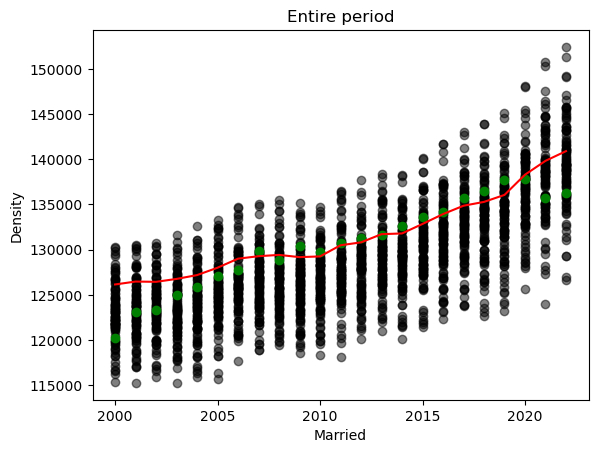

In [312]:
# UWAGA - lata są od największych w dół

for i in range(len(gen_1.y_sim)):
    plt.scatter(df['Year'], gen_1.y_sim[i], color='black', alpha = 0.5)

plt.plot(df['Year'], alpha*df['Income'] + beta, color='red') 
plt.scatter(df['Year'], df['Married'], color='green')
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.show()

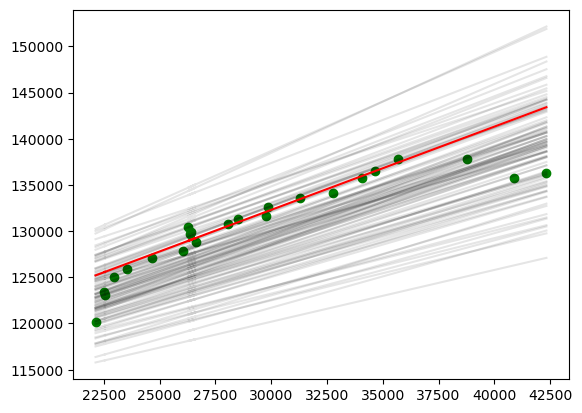

In [313]:
for i in range(len(gen_1.y_sim)):
    plt.plot(df['Income'], gen_1.alpha[i]*df['Income'] + gen_1.beta[i], color='black', alpha = 0.1)
plt.plot(df['Income'], gen_1.alpha[i].mean()*df['Income'] + gen_1.beta.mean(), color='red')   
plt.scatter(df['Income'], df['Married'], color='green')
plt.show()

In [314]:
data_post = {'N': N, 'y': df['Married'], 'income': df['Income']}
fit_1 = post_model.sample(
                    data=data_post, chains=1,
                    iter_sampling=R)

16:40:21 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                     


16:40:21 - cmdstanpy - INFO - CmdStan done processing.


In [315]:
fit_1.draws_pd()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,sigma,...,log_lik[14],log_lik[15],log_lik[16],log_lik[17],log_lik[18],log_lik[19],log_lik[20],log_lik[21],log_lik[22],log_lik[23]
0,-5215.26,0.589772,0.148605,1.0,1.0,0.0,5215.27,0.176322,125691.0,3196.94,...,-9.01422,-9.11875,-9.26006,-9.33833,-9.79239,-10.0730,-10.6191,-10.3357,-9.37482,-9.47200
1,-5215.99,0.963782,0.148605,2.0,7.0,0.0,5216.94,0.167607,125243.0,3188.30,...,-9.08625,-9.25480,-9.45114,-9.55673,-10.11800,-10.4508,-11.0843,-10.7760,-9.62798,-9.75706
2,-5212.45,0.998797,0.148605,2.0,5.0,0.0,5215.86,0.170750,125645.0,3197.63,...,-9.03150,-9.15490,-9.31321,-9.40065,-9.88831,-10.1854,-10.7596,-10.4730,-9.45362,-9.56243
3,-5210.35,0.999845,0.148605,4.0,15.0,0.0,5212.69,0.135827,126551.0,3202.71,...,-9.04594,-9.18154,-9.36257,-9.47152,-10.00970,-10.3345,-10.9615,-10.7204,-9.62369,-9.76941
4,-5210.67,0.931443,0.148605,2.0,7.0,0.0,5211.00,0.137440,126629.0,3213.55,...,-9.03673,-9.16023,-9.32989,-9.43269,-9.94824,-10.2616,-10.8690,-10.6320,-9.57360,-9.71198
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-5212.29,0.962855,0.148605,4.0,31.0,0.0,5215.59,0.165706,125632.0,3286.25,...,-9.07184,-9.20251,-9.36532,-9.45541,-9.94266,-10.2366,-10.8019,-10.5296,-9.52092,-9.63337
96,-5211.13,0.972824,0.148605,5.0,31.0,0.0,5214.86,0.130339,126626.0,3161.20,...,-9.04410,-9.19145,-9.38647,-9.50459,-10.07530,-10.4179,-11.0779,-10.8358,-9.68216,-9.84095
97,-5213.17,0.809401,0.148605,4.0,31.0,0.0,5216.00,0.161389,126056.0,3183.38,...,-9.01613,-9.12894,-9.28243,-9.37071,-9.85346,-10.1499,-10.7259,-10.4559,-9.44478,-9.55823
98,-5212.26,1.000000,0.148605,1.0,1.0,0.0,5213.05,0.160487,126003.0,3183.85,...,-9.02287,-9.14284,-9.30251,-9.39387,-9.88836,-10.1904,-10.7758,-10.5034,-9.47227,-9.58930


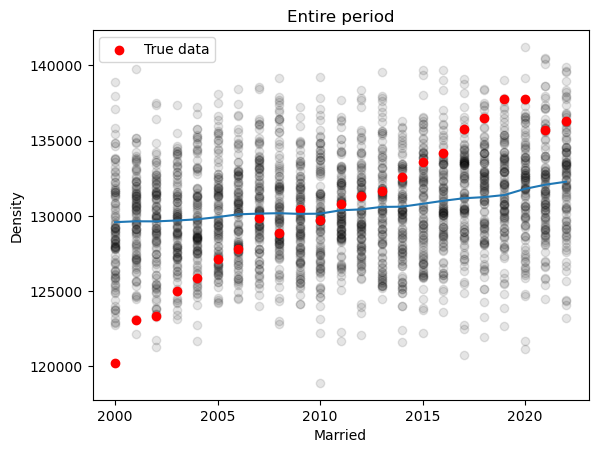

In [316]:
for i in range(len(fit_1.y_sim)):
    plt.scatter(df['Year'], fit_1.y_sim[i], alpha = 0.1, color="black")
plt.scatter(df['Year'], df['Married'], label= 'True data', color="red")
plt.plot(df['Year'], fit_1.alpha.mean()*df['Income'] + fit_1.beta.mean())
plt.title('Entire period')
plt.ylabel('Density')
plt.xlabel('Married')
plt.legend()
plt.show()

### 5. Posterior (model 1) - analiza

- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
- have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

In [317]:
az.summary(fit_1)

arviz - WARNING - Shape validation failed: input_shape: (1, 100), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.133,0.026,0.087,0.176,0.004,0.003,54.0,41.0,NaN
beta,126634.780,756.751,125496.000,128071.000,102.094,72.586,56.0,23.0,NaN
sigma,3217.247,41.702,3146.960,3293.170,5.607,3.991,59.0,74.0,NaN
y_sim[0],129150.660,3499.997,122727.000,134845.000,398.535,283.016,78.0,113.0,NaN
y_sim[1],129912.300,2995.729,124488.000,134907.000,284.851,201.953,116.0,102.0,NaN
y_sim[2],129347.890,3346.814,123297.000,134869.000,350.800,248.852,93.0,87.0,NaN
y_sim[3],129587.480,2971.407,124206.000,134647.000,295.130,211.144,106.0,78.0,NaN
y_sim[4],129718.680,3226.613,124599.000,135794.000,352.941,250.443,79.0,78.0,NaN
y_sim[5],130118.990,3292.005,124232.000,135651.000,251.609,178.218,181.0,115.0,NaN
y_sim[6],130195.570,3086.591,124502.000,135556.000,291.230,206.468,111.0,112.0,NaN


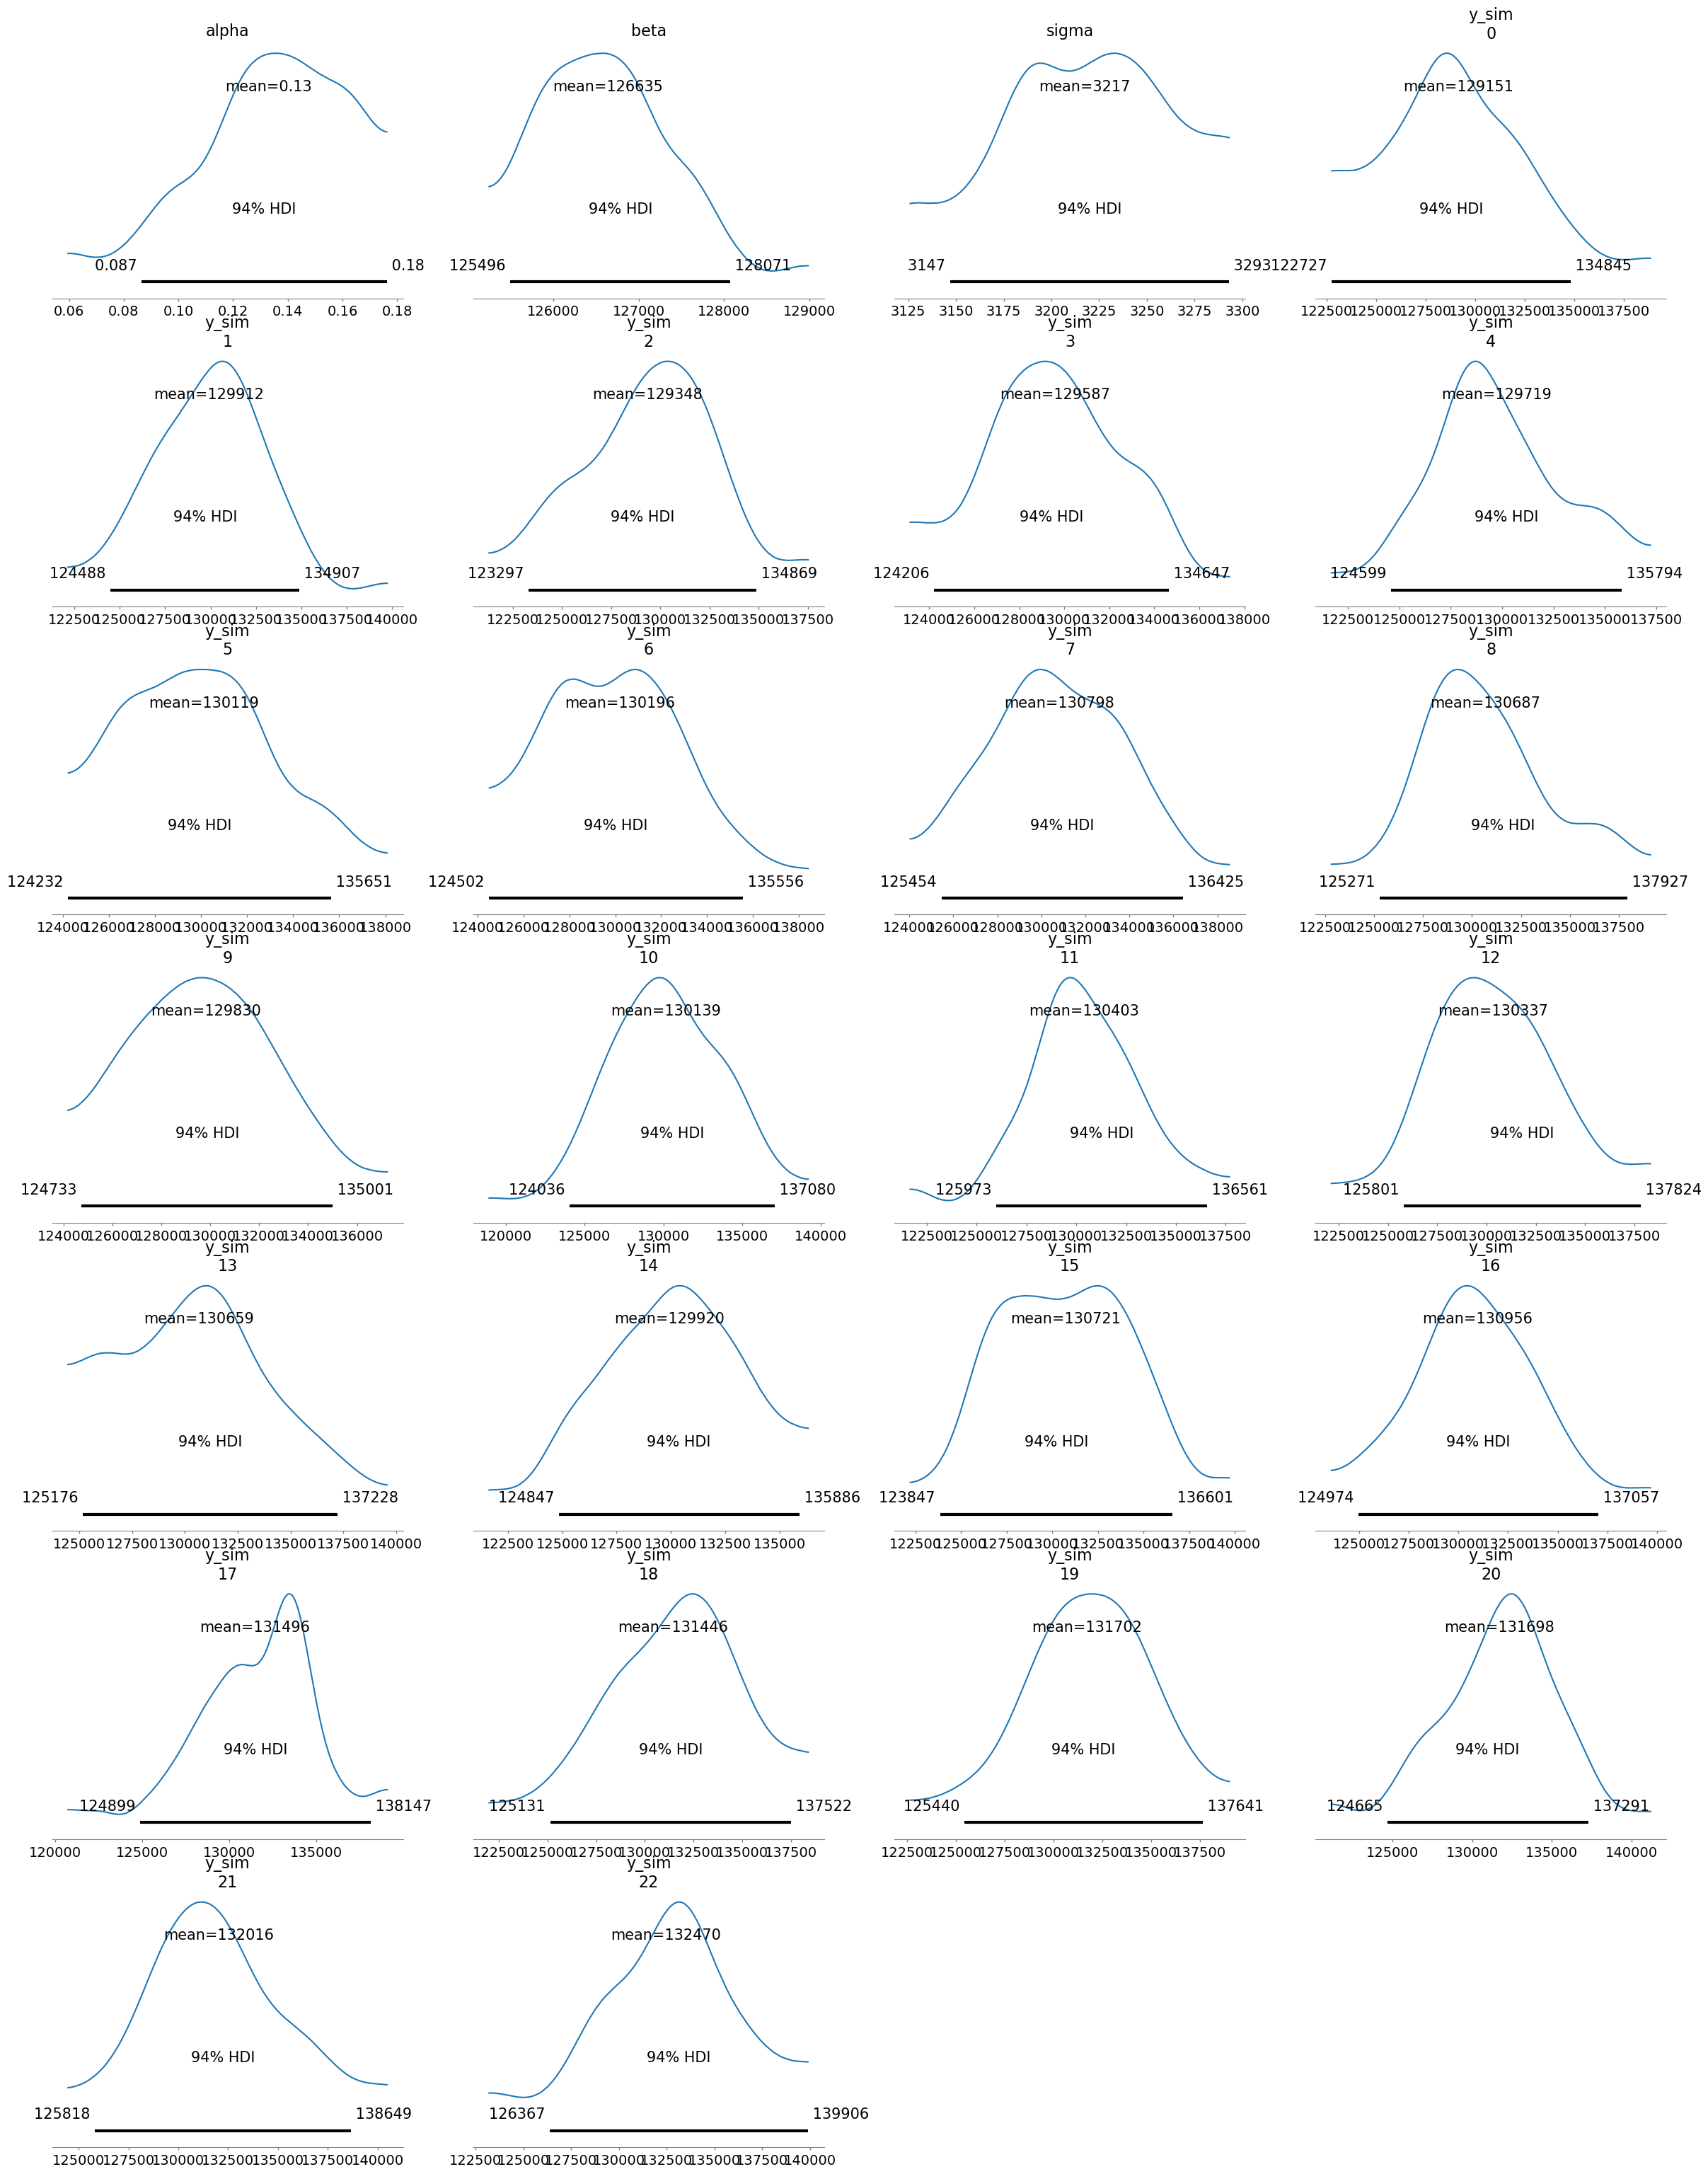

In [318]:
az.plot_posterior(fit_1)
plt.show()

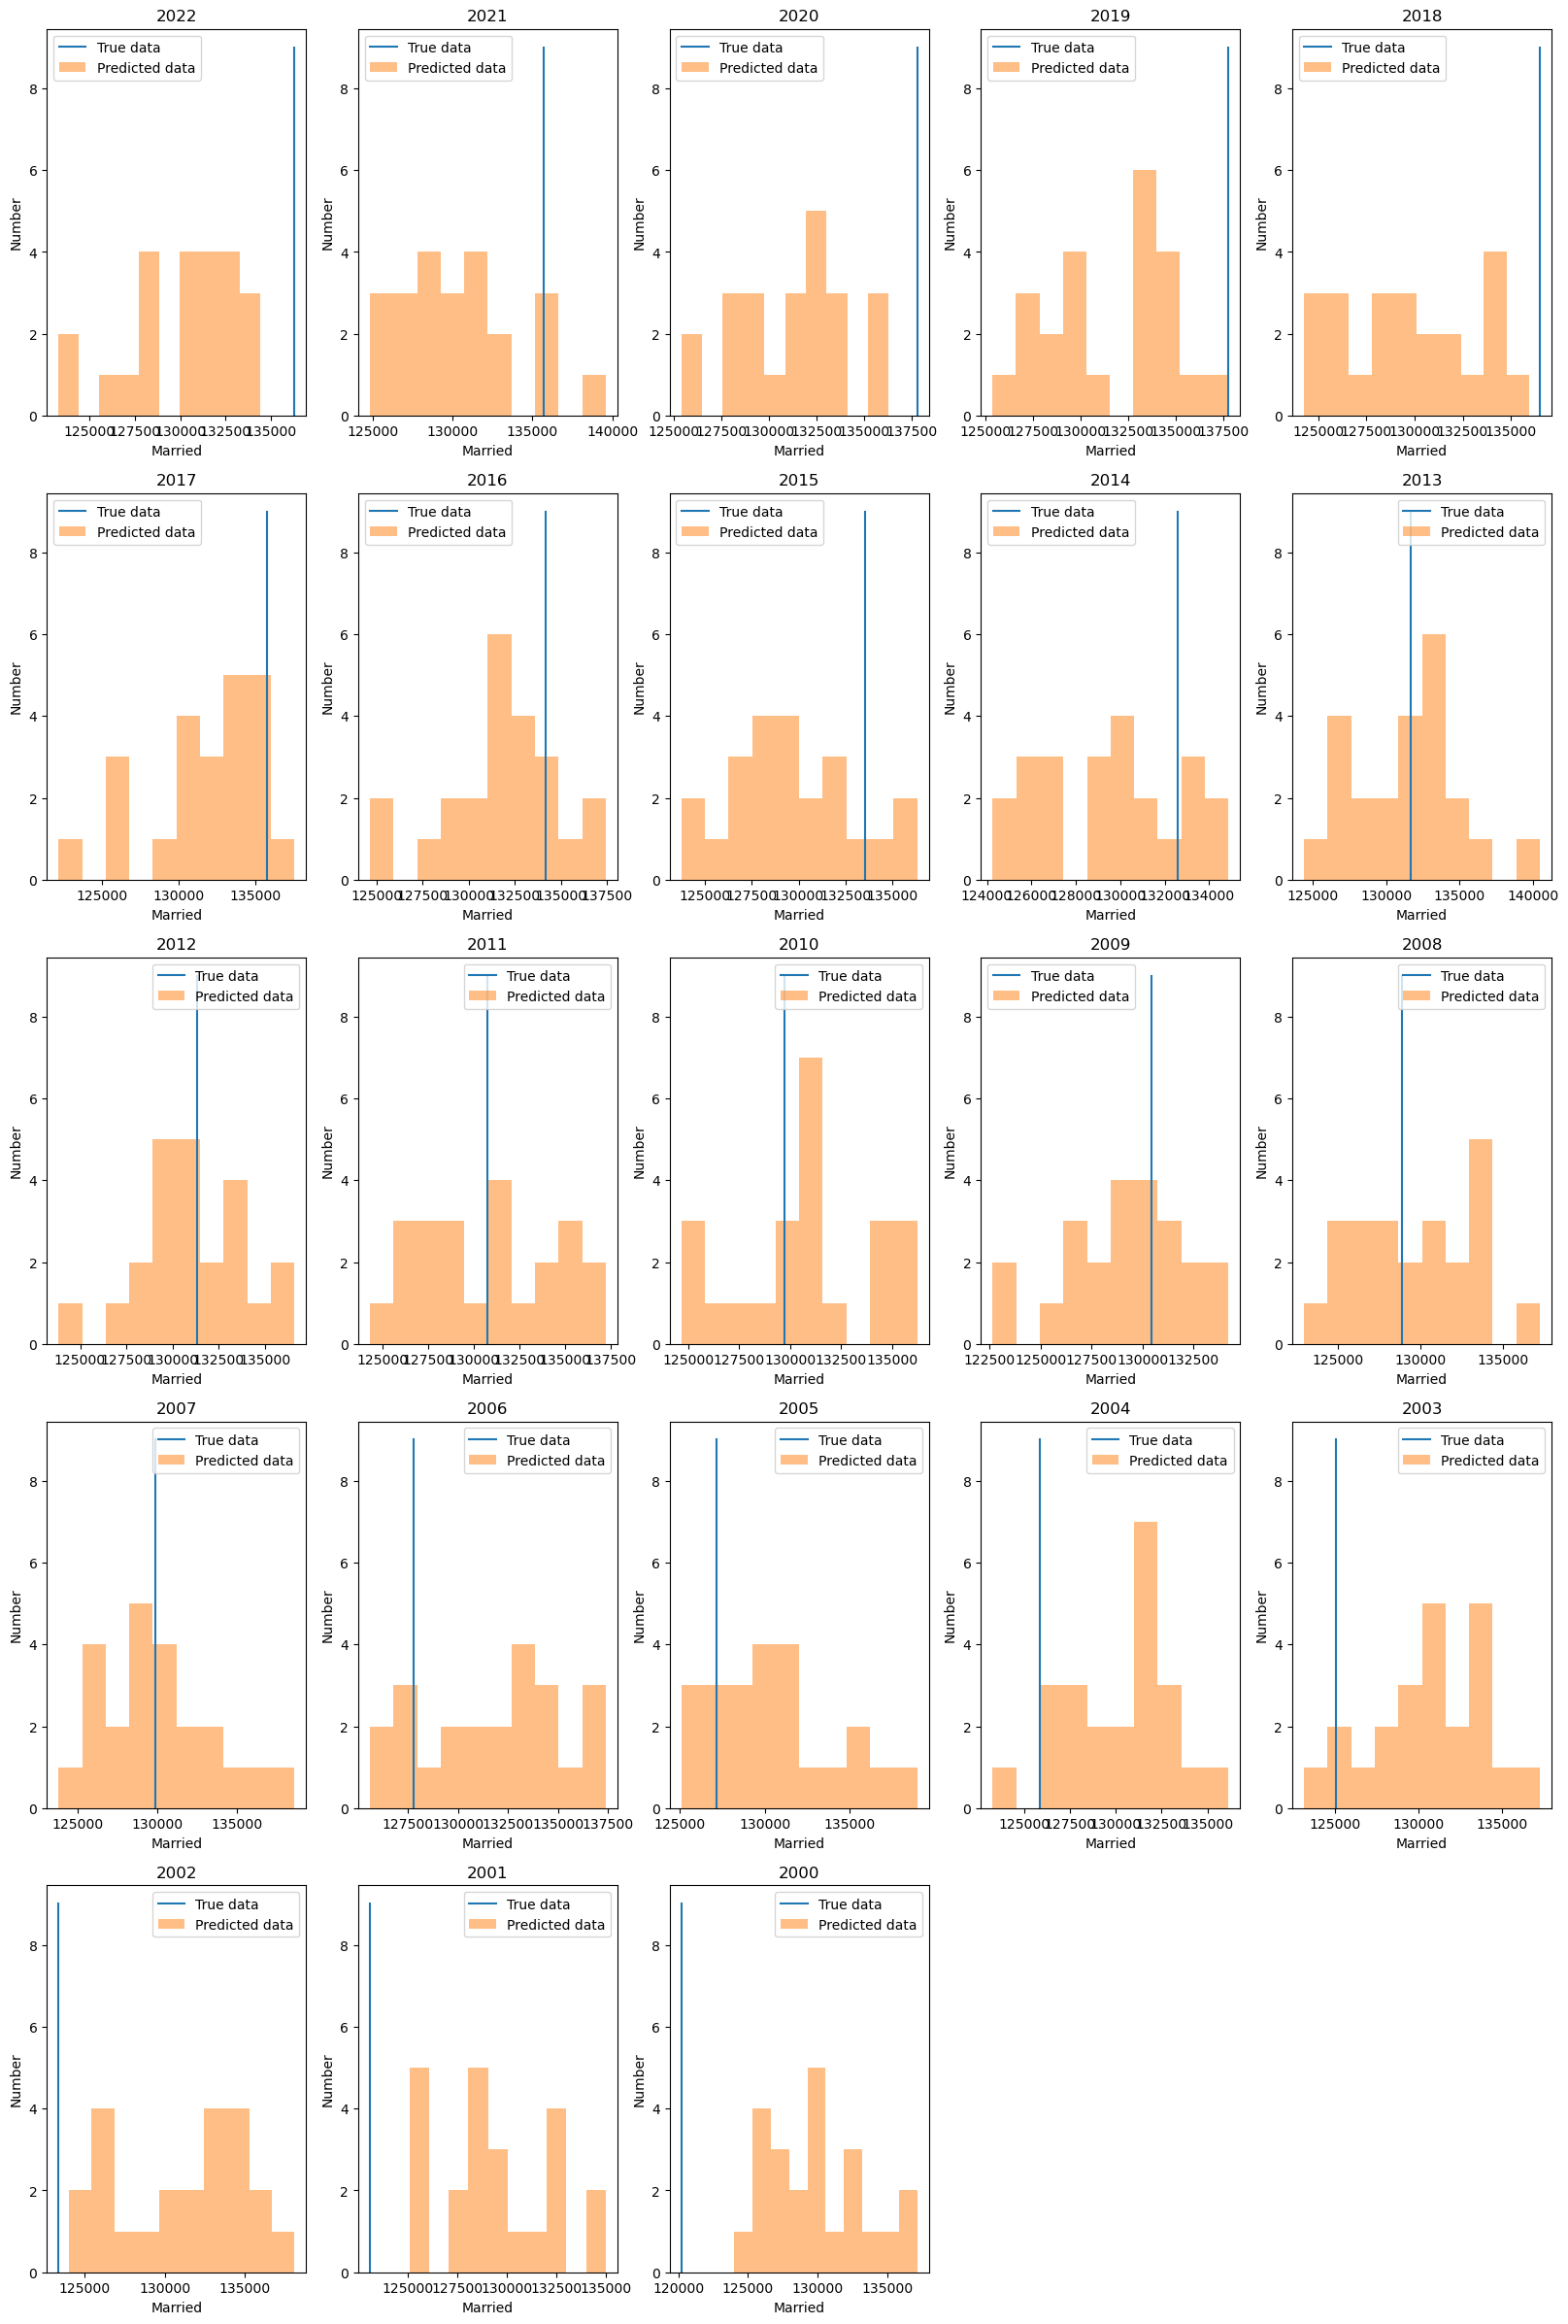

In [319]:
n=1
plt.figure(figsize=(20,30))
for i in range(len(df)):
    plt.subplot(5,5,n)
    plt.plot([df['Married'][i]]*10, range(0,10), label= 'True data')
    plt.hist(fit_1.y_sim[i], bins=10, alpha = 0.5, label = 'Predicted data')
    plt.title(df['Year'][i])
    plt.ylabel('Number')
    plt.xlabel('Married')
    plt.legend()
    n+=1

plt.show()

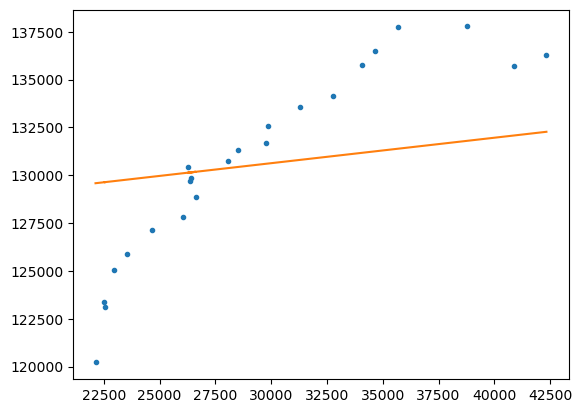

In [320]:
alpha = np.mean(fit_1.alpha)
beta = np.mean(fit_1.beta)
plt.plot(df['Income'], df['Married'],'.')
plt.plot(df['Income'], alpha*df['Income'] + beta) 
plt.show()

### 6. Posterior (model 2) - analiza

- were there any issues with the sampling? if there were what kind of ideas for mitigation were used [1 pt]
- are the samples from posterior predictive distribution analyzed [1 pt]
- are the data consistent with posterior predictive samples and is it sufficiently commented (if they are not then is the justification provided)
- have parameter marginal disrtibutions been analyzed (histograms of individual parametes plus summaries, are they diffuse or concentrated, what can we say about values) [1 pt]

In [324]:
data = {'N': N,'income': df['Income'], 'household': df['Household']}
gen_1 = model_2_prior.sample(
                    data=data,
                    iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

16:41:17 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


16:41:17 - cmdstanpy - INFO - CmdStan done processing.


In [326]:
data_post = {'N': N, 'y': df['Married'], 'income': df['Income'], 'household': df['Household']}
fit_2 = model_2_posterior.sample(
                    data=data_post, chains=1,
                    iter_sampling=R)


16:41:36 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:02 Sampling completed                     


16:41:38 - cmdstanpy - INFO - CmdStan done processing.


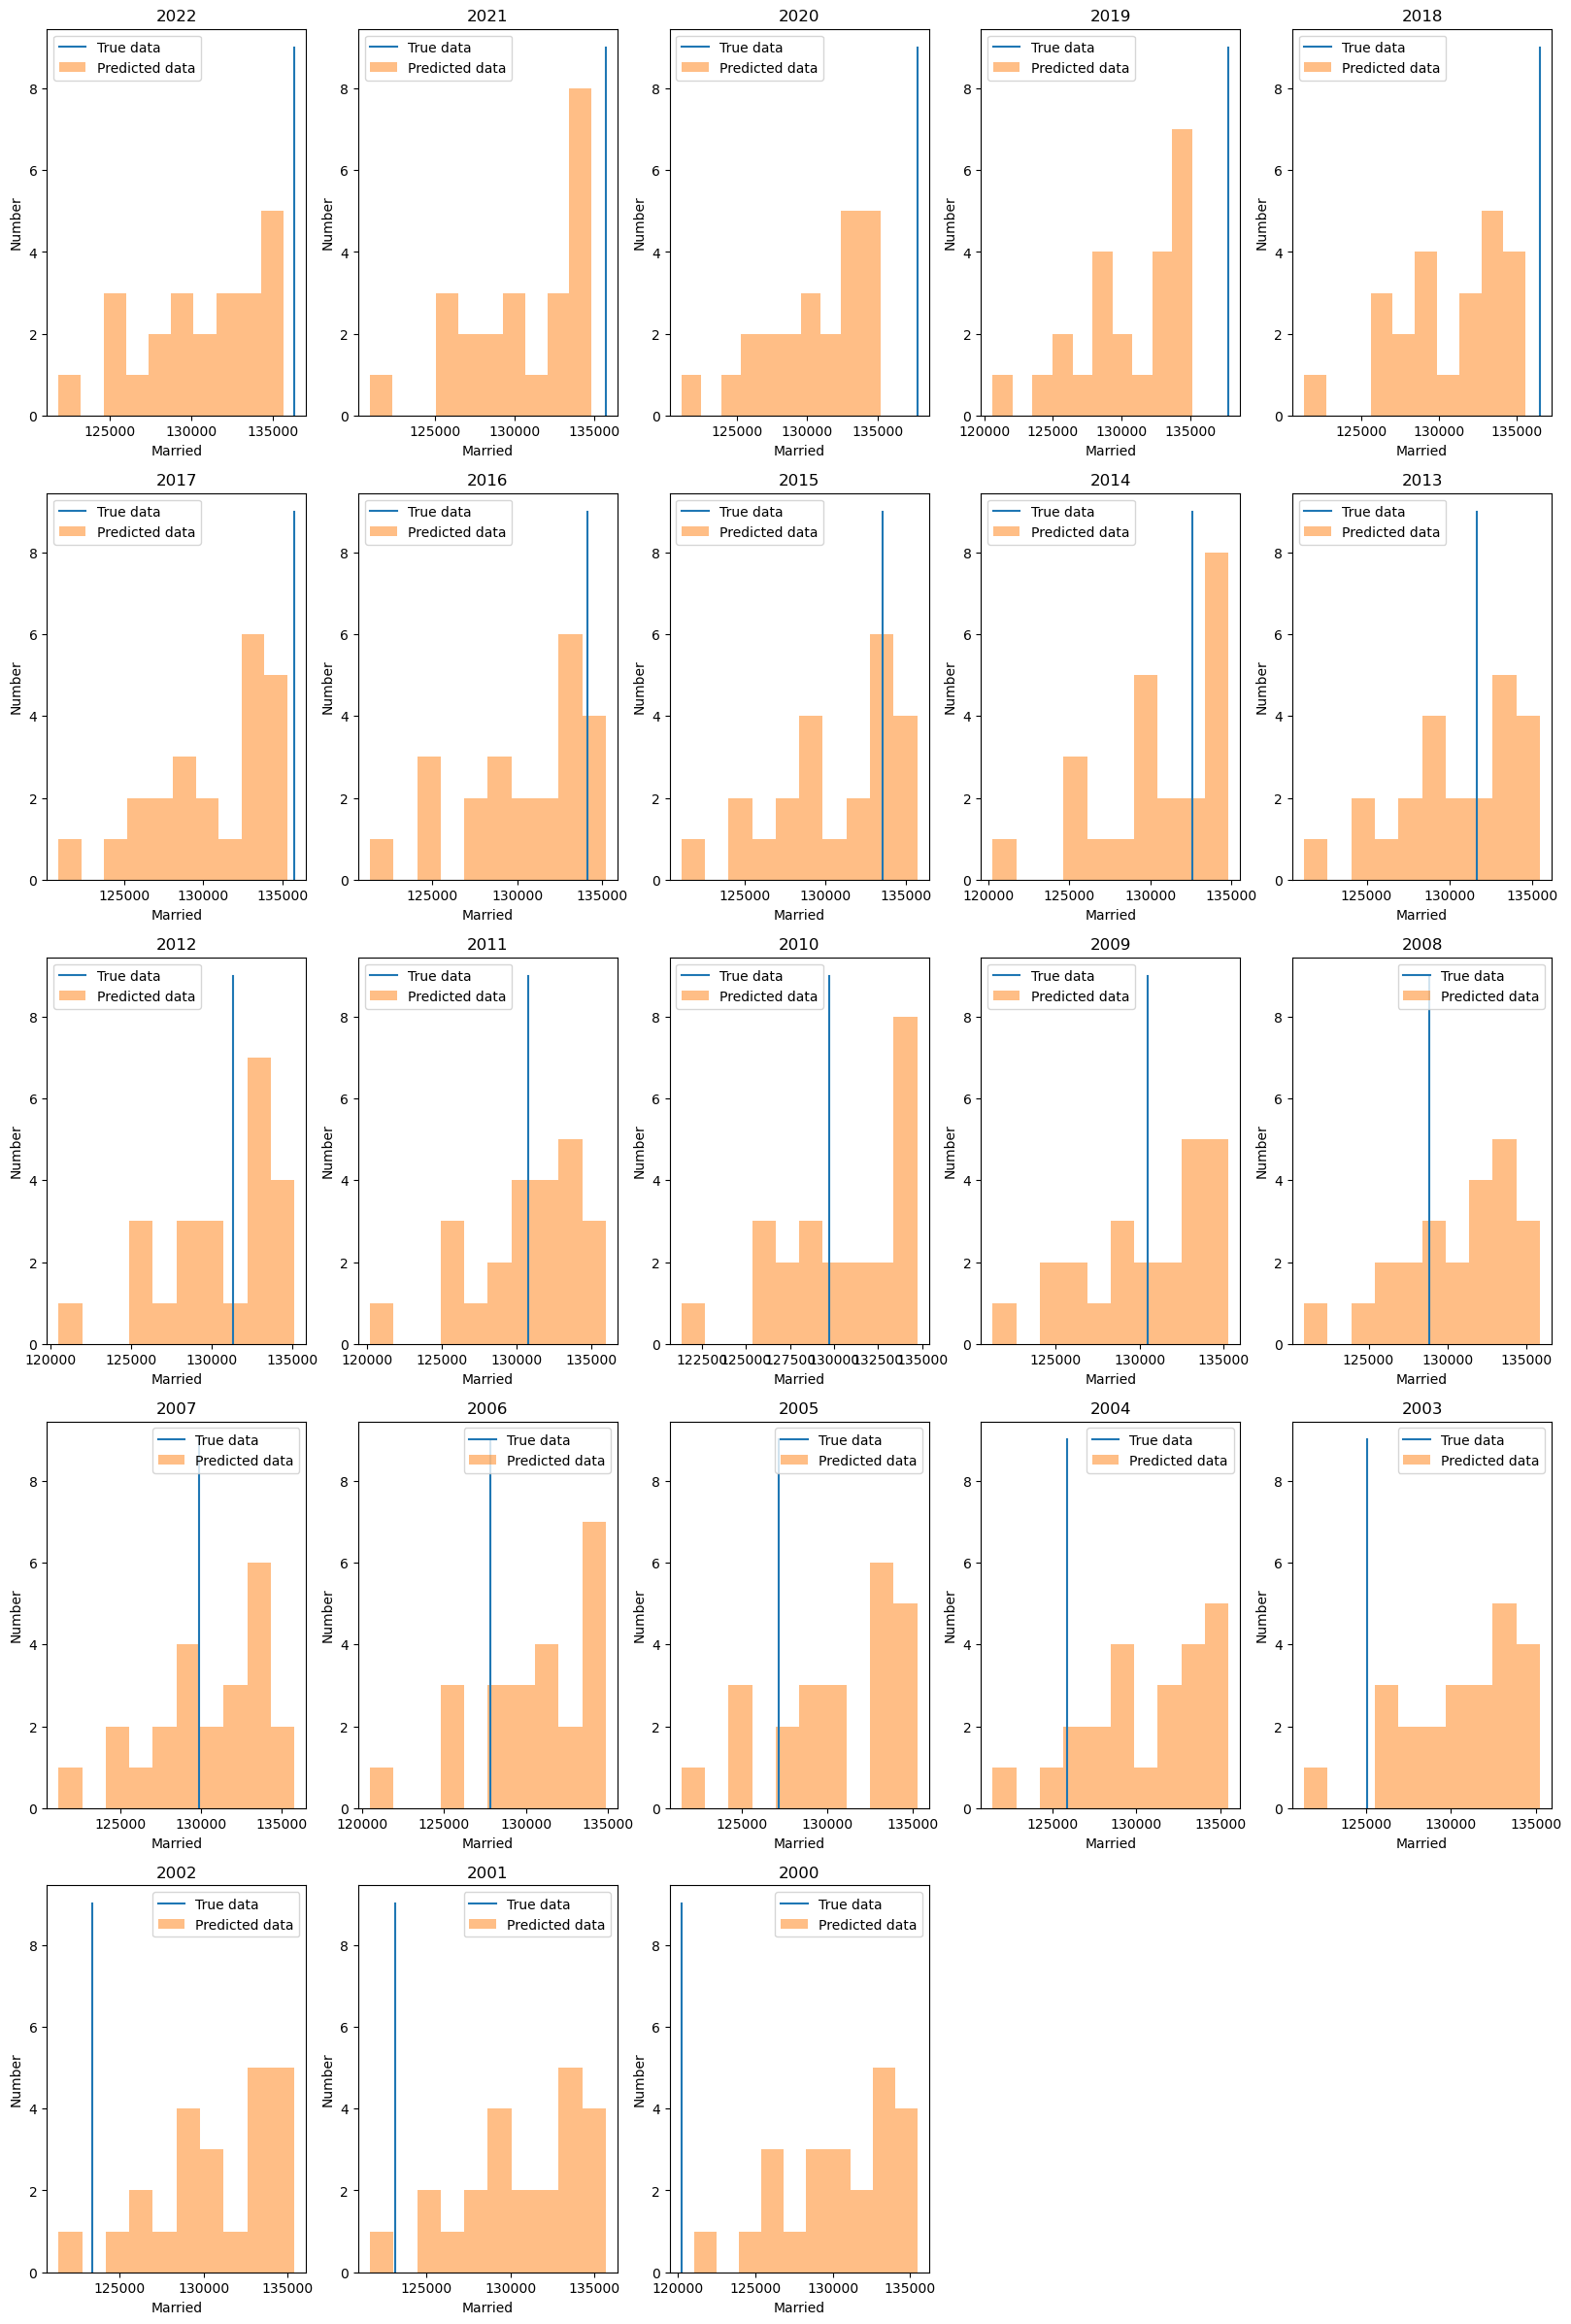

In [334]:
n=1
plt.figure(figsize=(20,30))
for i in range(len(df)):
    plt.subplot(5,5,n)
    plt.plot([df['Married'][i]]*10, range(0,10), label= 'True data')
    plt.hist(fit_2.y_sim[i], bins=10, alpha = 0.5, label = 'Predicted data')
    plt.title(df['Year'][i])
    plt.ylabel('Number')
    plt.xlabel('Married')
    plt.legend()
    n+=1

plt.show()

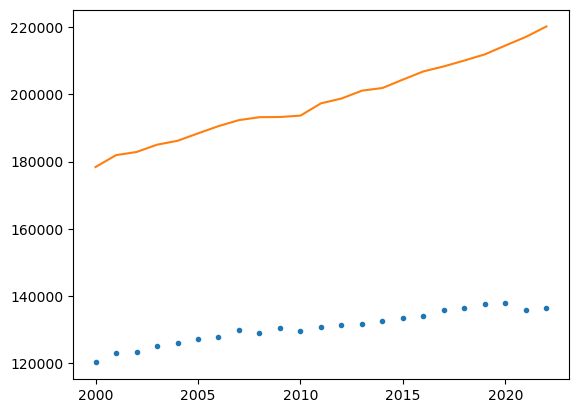

In [333]:
alpha1 = np.mean(fit_2.alpha_1)
alpha2 = np.mean(fit_2.alpha_2)
beta = np.mean(fit_2.beta)
plt.plot(df['Year'], df['Married'],'.')
plt.plot(df['Year'], alpha1*df['Income'] + alpha1*df['Household'] + beta) 
plt.show()

### 7. Porównanie modeli

- Have models been compared using information criteria [1 pt]
- Have result for WAIC been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Have result for PSIS-LOO been discussed (is there a clear winner, or is there an overlap, were there any warnings) [1 pt]
- Whas the model comparison discussed? Do authors agree with information criteria? Why in your opinion one model better than another [1 pt]

In [327]:
# Compare the models using WAIC
waic_compare = az.compare({"income": fit_1, "Income/household": fit_2}, ic="waic")

print("WAIC comparison:")
waic_compare


WAIC comparison:


,rank,elpd_waic,p_waic,elpd_diff,weight,se,dse,warning,scale
income,0,-226.377171,0.239489,0.00000,1.000000e+00,4.784744,0.000000,False,log
Income/household,1,-31616.466911,30312.593700,31390.08974,3.794298e-12,10975.642419,10972.063655,True,log


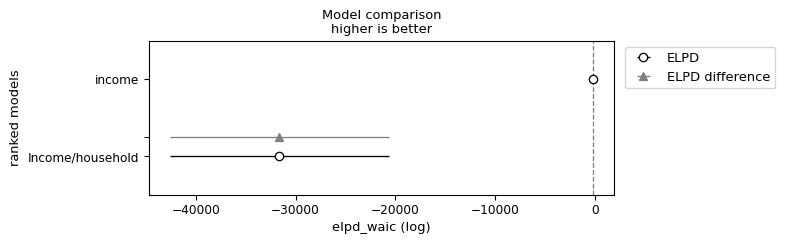

In [328]:
az.plot_compare(waic_compare)
plt.show()

In [331]:
# Compare the models using LOO
loo_compare = az.compare({"income": fit_1, "Income/household": fit_2}, ic="loo")

print("Loo comparison:")
loo_compare


Loo comparison:


,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
income,0,-226.383287,0.245606,0.000000,1.0,4.786746,0.000000,False,log
Income/household,1,-2742.353588,1438.480377,2515.970301,0.0,582.399083,579.701881,True,log


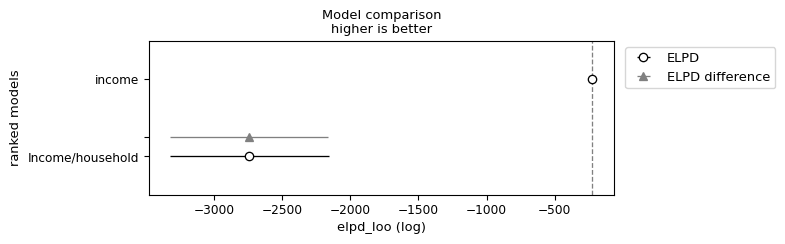

In [332]:
az.plot_compare(loo_compare)
plt.show()